In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.dpi"] = 100
import plotly.graph_objects as go
# import warnings
# warnings.filterwarnings("error")

In [24]:
arr = np.ones(5)
print(arr)
i = 5
np.sum(arr[4:])

[1. 1. 1. 1. 1.]


1.0

In [5]:
T = 0.1

a = 0
b = 1

h = 0.01
tau = 0.01

M = int(T/tau) + 1
N = int((b-a)/h) + 1

K = lambda u, x, t: u**2

U = np.zeros((M, N))
Psi = np.ones(N-1)
Q = np.zeros(N)

Psis = [Psi.copy()]

for n in range(N):
    U[0][n] = 10

for m in range(1, M):
    # tau = 0.001
    for n in range(1, N - 1):
        # Q[0] = 0
        # for i in range(1, N - 1):
        #     # if np.abs(A[m-1][i+1] - A[m-1][i-1]) < 0.01 or np.abs(Psi[i]+Psi[i-1]) < 0.01:
        #     #     Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
        #     #             K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
        #     #             2/h/0.01/ 0.01
        #     # else:
        #     #     try:
        #     #         Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
        #     #                 K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
        #     #                 2/h/(Psi[i]+Psi[i-1])/(A[m-1][i+1] - A[m-1][i-1])
        #     #     except:
        #     #         pass
        #     # if Psi[i-1] + tau/h*(Q[i-1]-Q[i]) < 0:
        #     #     Q[i] = h/tau*Psi[i-1]/2 + Q[i-1]
        #     # else:
        #     #     Q[i] += h/tau*Psi[i-1]/2 + Q[i-1]
        #     # counted = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
        #     #                 K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
        #     #                 2/h/(Psi[i]+Psi[i-1])/(A[m-1][i+1] - A[m-1][i-1])
        #     # right =  h/tau*np.sum(Psi[:i])
        #     # left = -h/tau*np.sum(Psi[i:])
        #     # if  left < counted < right:
        #     #     Q[i] = counted
        #     # elif counted > right:
        #     #     Q[i] = right/2
        #     # elif counted < left:
        #     #     Q[i] = left/2
        #     # Q[i] = (left+right)/2
        #     Q[i] = 0
        # Q[N-1] = 0
        Q = np.zeros(N)
        
        # Psi_next = np.zeros(N-1)
        
        # taus = list()
        # for i in range(0, N-1):
        #     if Q[i] != Q[i+1]:
        #         taus.append(abs(h*Psi[i]/2/(Q[i+1] - Q[i])))
        # if len(taus) != 0:
        #     tau = min(taus)
        
        # for i in range(0, N - 1):
        #     Psi_next[i] = Psi[i] + tau/h*(Q[i]-Q[i+1])
        Psi_next = np.ones(N)
                
        # A[m][n] = (A[m-1][n] * (Psi[n] + Psi[n-1]) / 2 + tau / h**2 * \
        #     (K((A[m-1][n+1] + A[m-1][n])/2, (n+1/2)*h, (m-1)*tau) / Psi[n] * (A[m-1][n+1]-A[m-1][n]) \
        #     - \
        #     K((A[m-1][n] + A[m-1][n-1])/2, (n-1/2)*h, (m-1)*tau) / Psi[n-1] * (A[m-1][n]-A[m-1][n-1])) \
        #     - \
        #     tau / (2*h) * (Q[n+1] * A[m-1][n+1] - Q[n-1]*A[m-1][n-1])) * 2 / (Psi_next[n]+Psi_next[n-1])
        A = np.zeros((N, N))
        B = np.zeros(N)
        for m in range(0, N):
            if m == 0:
                A[m][0] = 1
            elif m == N-1:
                A[m][N-1] = 1
            else:
                A[m][m-1] = tau/2/h**2*(K(U[]))
                A[m][m] = 
                A[m][m+1] = 
            # if n != 1:
            #     Psi_n_prev = (Psi[n-1] + Psi[n-2])/2
            # Psi_n = (Psi[n] + Psi[n-1])/2
            # Psi_m_next = (Psi_next[n] + Psi_next[n-1])/2
            # # if n != 1:
            # A[n-1][n-2] = tau/2/h**2*(K(U[m-1][n], n*h, (m-1)*tau)/Psi_n + K(U[m-1][n-1], (n-1)*h, (m-1)*tau)/Psi_n_prev)
            # # else:
            # #     A[n-1][n-2] = 0
            # A[n-1][n-1] = -(Psi_m_next + tau/2/h**2*(K(U[m-1][n+1], (n+1)*h, (m-1)*tau)/Psi_n_next +\
            #                                         2*K(U[m-1][n], n*h, (m-1)*tau)/Psi_n +\
            #                                         K(U[m-1][n-1], (n-1)*h, (m-1)*tau)/Psi_n_prev))
            # # if n != N-2:
            # A[n-1][n] = tau/2/h**2*(K(U[m-1][n], n*h, (m-1)*tau)/Psi_n + K(U[m-1][n+1], (n+1)*h, (m-1)*tau)/Psi_n_next)
            # # else:
            # #     A[n-1][n] = 0
            # B[n-1] = tau/h*(Q[n+1]*U[m-1][n+1] - Q[n]*U[m-1][n]) - Psi_n*U[m-1][n]
            
        X = np.linalg.inv(A).dot(B)
        U[m] = X
        # A[m][n] = A[m-1][n] + tau/h**2*(K((A[m-1][n+1] + A[m-1][n])/2, (n+1/2)*h, (m-1)*tau)*(A[m-1][n+1]-A[m-1][n])\
        #     -\
        #     K((A[m-1][n] + A[m-1][n-1])/2, (n-1/2)*h, (m-1)*tau)*(A[m-1][n]-A[m-1][n-1]))

        Psi = np.copy(Psi_next)
        
        Psis.append(Psi.copy())
        

NameError: name 'Psi_n_next' is not defined

In [223]:
T = 0.01

a = 0
b = 1

h = 0.001
tau = 0.001

M = int(T/tau) + 1
N = int((b-a)/h) + 1

U = np.ones((M, N)) * 10
Q = np.zeros(N)
Psi = np.ones(N-1)
Psis = [Psi.copy()]

Kuxt = lambda u, x, t: np.power(u - 5, 2)
K = lambda m, n: Kuxt(U[m][n], n*h, m*tau)

for n in range(N):
    U[0][n] = 10
    # U[0][n] = -40*((n*h)-0.5)**2+10
    # U[0][n] = 10*np.sin(10*n*h)

for m in range(1, M):
    Q = np.zeros(N)
    Q[0] = 0
    for i in range(1, N - 1):
        # if np.abs(A[m-1][i+1] - A[m-1][i-1]) < 0.01 or np.abs(Psi[i]+Psi[i-1]) < 0.01:
        #     Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
        #             K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
        #             2/h/0.01/ 0.01
        # else:
        #     try:
        #         Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
        #                 K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
        #                 2/h/(Psi[i]+Psi[i-1])/(A[m-1][i+1] - A[m-1][i-1])
        #     except:
        #         pass
        # if Psi[i-1] + tau/h*(Q[i-1]-Q[i]) < 0:
        #     Q[i] = h/tau*Psi[i-1]/2 + Q[i-1]
        # else:
        #     Q[i] += h/tau*Psi[i-1]/2 + Q[i-1]
        counted = (K(m-1, i+1)*(U[m-1][i+1] - U[m-1][i]) - \
                    K(m-1, i-1)*(U[m-1][i] - U[m-1][i-1])) * \
                    2/h/(Psi[i]+Psi[i-1])/(U[m-1][i+1] - U[m-1][i-1])
        right =  h/tau*np.min(Psi[:i])
        left = -h/tau*np.min(Psi[i:])
        if left < counted < right:
            Q[i] = counted
        elif counted > right:
            Q[i] = right/2
        elif counted < left:
            Q[i] = left/2
        # Q[i] = (left+right)/2
        # Q[i] = 0
    Q[N-1] = 0

    Psi_next = np.ones(N-1)
    for i in range(0, N-1):
        Psi_next[i] = Psi[i] + tau/h*(Q[i]-Q[i+1])
            
    A = np.zeros((N, N))
    B = np.zeros(N)
    for n in range(0, N):
        if n == 0:
            A[n][0] = 1
            # B[n] = 0
        elif n == N-1:
            A[n][N-1] = 1
        else:
            Psi_nM1 = (Psi[n-2] + Psi[n-1])/2
            Psi_n = (Psi[n-1] + Psi[n])/2
            Psi_nP1 = (Psi[n] + Psi[n] if n == N-2 else Psi[n+1])/2
            Psi_n_next = (Psi_next[n-1] + Psi_next[n])/2
            A[n][n-1] = tau/2/h**2*(K(m-1, n+1)/Psi_nP1+K(m-1, n)/Psi_n)
            A[n][n] = Psi_n_next+tau/2/h**2*(K(m-1, n+1)/Psi_nP1+2*K(m-1, n)/Psi_n+K(m-1, n-1)/Psi_nM1)
            A[n][n+1] = tau/2/h**2*(K(m-1, n)/Psi_n+K(m-1, n-1)/Psi_nM1)
            B[n] = tau/h*(Q[n+1]*U[m-1][n+1]-Q[n]*U[m-1][n])-Psi_n*U[m-1][n]
        
    X = np.linalg.inv(A).dot(B)
    U[m] = X

    Psi = Psi_next.copy()
    
    Psis.append(Psi.copy())

/var/folders/f7/7qch0j_97lq6bw09jrgf100m0000gn/T/ipykernel_2296/944127994.py:44: RuntimeWarning:

invalid value encountered in double_scalars

/var/folders/f7/7qch0j_97lq6bw09jrgf100m0000gn/T/ipykernel_2296/944127994.py:76: RuntimeWarning:

divide by zero encountered in double_scalars

/var/folders/f7/7qch0j_97lq6bw09jrgf100m0000gn/T/ipykernel_2296/944127994.py:77: RuntimeWarning:

divide by zero encountered in double_scalars



In [224]:
Psi

array([0.75, 1.25, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

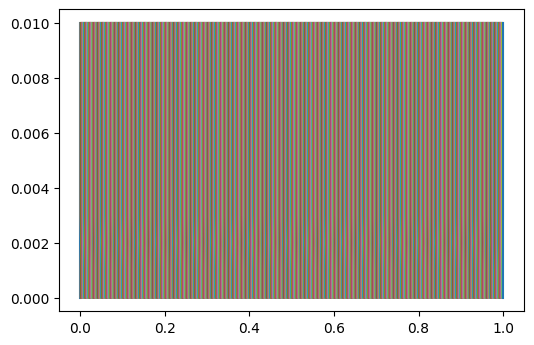

In [225]:
t = 0
graph = []
for i, Psi in enumerate(Psis):
    if i % 1 == 0:
        X = list()
        xi = 0
        X.append(xi)
        for psi in Psi:
            xi += psi * h
            X.append(xi)
        graph.append([X, list(np.full((len(X)), t))])
        # plt.scatter(X, np.full((len(X)), t), s=1, color='black')
        t += tau
graph = np.array(graph)
graph = graph.transpose()
# graph.shape, graph[0]
for l in graph:
    # l = line.transpose()
    plt.plot(l[0], l[1])
plt.show()

In [226]:
sh_0, sh_1 = A.shape
fig = go.Figure()
fig.add_surface(
    # contours = {
    #     "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
    #     "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    # },
    x = np.linspace(a, b, sh_1),
    y = np.linspace(0, T, sh_0),
    z = U
    )
# fig.add_scatter3d(name='scat_p', x=np.linspace(a, b, sh_1), y=np.linspace(0, T, sh_0), z=U, mode='markers',
#     marker=dict(size=10, color='black',colorscale='Reds'))
# fig.update_layout(
#         scene = {
#             "xaxis": {"nticks": 20},
#             "zaxis": {"nticks": 4},
#             'camera_eye': {"x": 0, "y": -1, "z": 0.5},
#             "aspectratio": {"x": 1, "y": 1, "z": 0.2}
#         })
fig.update_layout(title='surface', autosize=False,
                  width=500, height=500,
                  margin=dict(l=5, r=50, b=5, t=55))
fig.show()